<a href="https://colab.research.google.com/github/napatt2/QuakeNN/blob/main/Wave%20Equation/Fenics_foward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl_legacy
    import dolfin
else:
    try:
        import ufl_legacy
        import dolfin
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        import ufl_legacy
        import dolfin

In [26]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
from IPython import display


E = 32
nu = 0.25
rho = 2.7

# compute shear wave speed

cs = np.sqrt(E/rho)
print(f"Shear wave speed: {cs:.3f} m/s")

T = 0.5

Lx = 3.5
Ly = 3.5

nnodes = 200

mesh = RectangleMesh(Point(0, 0), Point(Lx, Ly), nnodes, nnodes)

# compute CFL condition

elem_l = Lx/nnodes
dt = 0.5*elem_l/(2*cs)
print(f"dt: {dt}")
num_steps = int(T/dt)


V = VectorFunctionSpace(mesh, "CG", 1)

# define trial and test function
u = TrialFunction(V)
v = TestFunction(V)

# define solution at current and prior time
u_n = Function(V)
u_p = Function(V)
A = 1

u_n = interpolate(Expression(("x[0] < 0.1 ? A*sin(pi/Ly*x[1]) : 0.0", "0.0"),
                           A=A,Ly=Ly, degree=1), V)

def right_boundary(x, on_boundary):
    return on_boundary and near(x[0], Lx)


bc = [DirichletBC(V, Constant((0, 0)), right_boundary)]


Shear wave speed: 3.443 m/s
dt: 0.001270822660474309


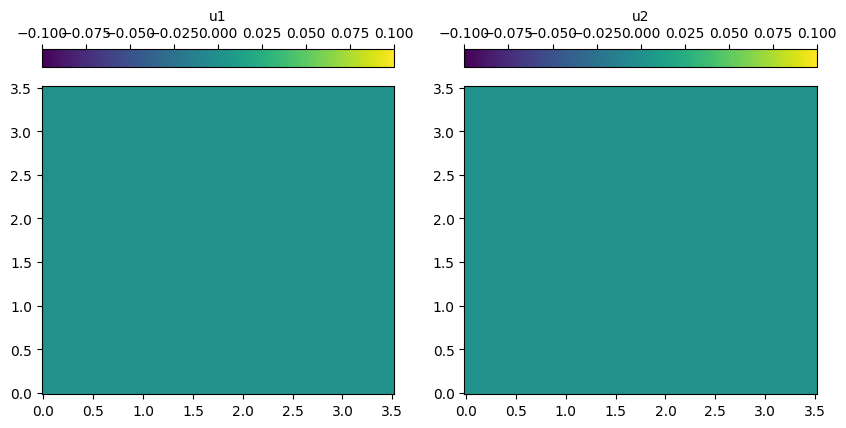

In [27]:
# strain tensor

def epsilon(u):
    return sym(grad(u))

# stress tensor
def sigma(u):
    eps = epsilon(u)
    return (E/(1.0 - nu**2))*((1.0 - nu)*eps + nu*tr(eps)*Identity(2))
# Mass

m = rho*inner(u,v)*dx

# Stiffness
k = inner(sigma(u), epsilon(v))*dx


# Assemble
M = assemble(m)
K = assemble(k)

for bcs in bc:
  bcs.apply(M)
  bcs.apply(K)


# Vector

solver = LUSolver()

# visualization
plt.ion()
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
nx_vis, ny_vis = 100, 100
x = np.linspace(0, Lx, nx_vis)
y = np.linspace(0, Ly, ny_vis)
X, Y = np.meshgrid(x, y)

u1_grid = np.zeros((ny_vis, nx_vis))
u2_grid = np.zeros((ny_vis, nx_vis))
im1 = ax1.pcolormesh(X, Y, u1_grid, shading='auto')
im2 = ax2.pcolormesh(X, Y, u2_grid, shading='auto')

# Create colorbars once, outside the loop
cbar1 = plt.colorbar(im1, ax=ax1, label='u1',location='top',orientation='horizontal')
cbar2 = plt.colorbar(im2, ax=ax2, label='u2',location='top',orientation='horizontal')

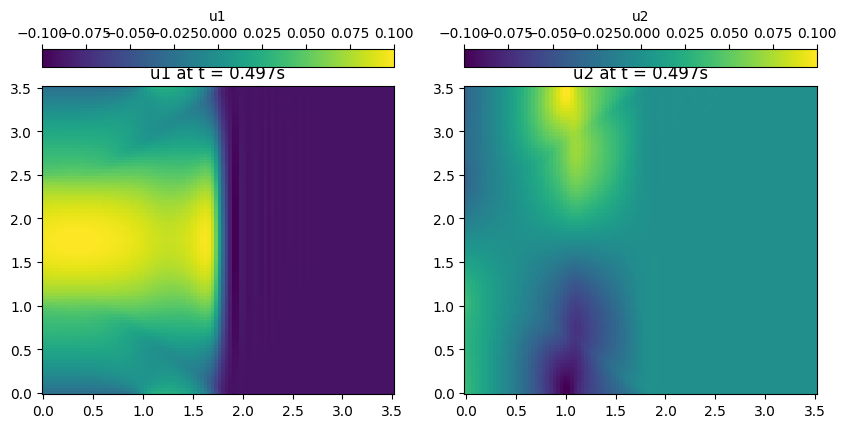

t = 0.497
t = 0.498
t = 0.499
t = 0.501


In [28]:
t = 0
step = 0

while t < T:
    t += dt

    # Update load vector
    b = 2*M*u_n.vector() - dt*dt*K*u_n.vector() - M*u_p.vector()

    u_p.assign(u_n)

    # Solve
    solver.solve(M, u_n.vector(), b)
    #
    # Visualize every few time steps
    if step % 10 == 0:
        # Convert to numpy arrays for plotting
        u1_func = u_p.sub(0)
        u2_func = u_p.sub(1)

        u1_grid = np.zeros((ny_vis, nx_vis))
        u2_grid = np.zeros((ny_vis, nx_vis))

        for i in range(ny_vis):
            for j in range(nx_vis):
                point = Point(x[j], y[i])
                try:
                    u1_grid[i,j] = u1_func(point)
                    u2_grid[i,j] = u2_func(point)
                except:
                    pass

        # Plot
        ax1.clear()
        ax2.clear()

        im1 = ax1.pcolormesh(X, Y, u1_grid, shading='auto')

        ax1.set_title(f'u1 at t = {t:.3f}s')

        im2 = ax2.pcolormesh(X, Y, u2_grid, shading='auto')

        ax2.set_title(f'u2 at t = {t:.3f}s')

        # Update colorbar limits if needed
        im1.set_clim(u1_grid.min(), u1_grid.max())
        im2.set_clim(u2_grid.min(), u2_grid.max())

        display.clear_output(wait=True)
        display.display(fig)

        plt.pause(1)

    # Update solution

    step += 1


    print(f"t = {t:.3f}")

plt.ioff()
plt.show()